In [2]:
import scipy.io
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from sklearn.metrics import mean_squared_error

In [3]:
mat = scipy.io.loadmat('Xtrain.mat')
data = mat['Xtrain']

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 800 for train, 200 for test
train_data = scaled_data[:800]
test_data = scaled_data[800:]

predict_length = 200

In [11]:
def train(ws,verbose=0):
    window_size = ws  # number of past steps to use

    X, y = [], []
    for i in range(window_size,len(train_data) - window_size - predict_length + 1):
        X.append(train_data[i-window_size:i])
        y.append(train_data[i])
    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(window_size, 1)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1)) 
    model.compile(optimizer='adam', loss='mse')

    model.fit(X, y, epochs=20, batch_size=32,verbose=verbose)

    return model

In [25]:
def test(ws,model,verbose=0):
    window_size = ws
    # Predicting next 200 values 1 value at a time
    current_seq = train_data[-window_size:].flatten().tolist()
    predictions = []

    for _ in range(len(test_data)):
        input_seq = np.array(current_seq[-window_size:]).reshape(1, window_size, 1)
        next_pred = model.predict(input_seq,verbose=verbose)[0][0]
        predictions.append(next_pred)
        current_seq.append(next_pred)

    # print("Predicted next 200 values:")
    # print(predictions)

    true_test = test_data.flatten()
    predicted = np.clip(np.array(predictions).flatten(),-10000,10000)

    return true_test, predicted


def evaluate(true_test: np.ndarray,predicted:np.ndarray,window_size: int):
    mse = mean_squared_error(true_test, predicted)
    print(f"windows size {window_size} -> Mean Squared Error:", mse)

    plt.figure(figsize=(20,3))
    plt.ylim((0,1))
    plt.title(f"WS: {window_size}. MSE: {mse}")
    plt.plot(true_test,c='green')
    plt.plot(predicted)

    SE = (predicted - true_test) ** 2
    plt.plot(SE,c='pink')
    plt.savefig(f"plots/prediction ws{window_size}.png")
    plt.close()

    return {"window_size":window_size,"mse":mse}

In [ ]:
results = []

min_window_size = 1
max_window_size = 100

for i in range(min_window_size,max_window_size):
    ws = i
    model = train(ws,0)
    true_test,predicted = test(ws,model,0)
    res = evaluate(true_test,predicted, ws)
    results.append(res)


windows size 1 -> Mean Squared Error: 0.031593941522967975
windows size 2 -> Mean Squared Error: 0.038989447729781156
windows size 3 -> Mean Squared Error: 0.03426583584399233
windows size 4 -> Mean Squared Error: 0.029679538246991474
windows size 5 -> Mean Squared Error: 0.019896055560888512


In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv("RNN_testingresults.csv")
results_df[results_df['mse']<0.035].sort_values(by='mse')

,window_size,mse
20,21,0.018302
17,18,0.021826
28,29,0.022942
2,3,0.023244
13,14,0.030700
12,13,0.030947
0,1,0.031203
34,35,0.032269
26,27,0.032371
27,28,0.032412


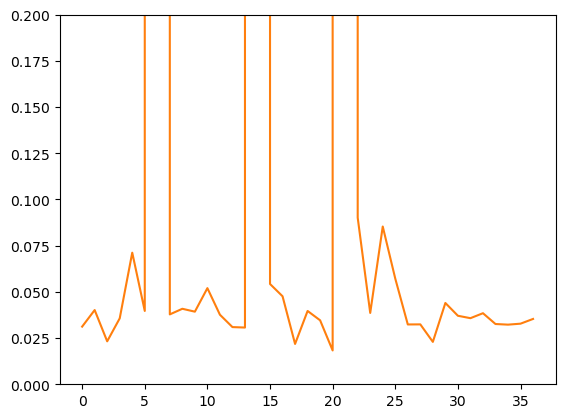

In [17]:
plt.ylim((0,0.2))
plt.plot(results_df)

In [30]:
results[49]

{'window_size': 50, 'mse': 0.03087220625339162}